# Prerequesites and Imports

Installs all of the prerequesites, in the future might be more useful to use preexisting libraries so that I dont have to build models from scratch

In [15]:
from __future__ import absolute_import, division, print_function
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import imageio
import IPython
import os
import gc
import pprint
from IPython.display import HTML
from IPython.display import clear_output
from sklearn import model_selection
import time
from PIL import Image
import copy


#import pyvirtualdisplay

from IPython import display as ipythondisplay

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Model and Helper Funcitons

For this project I chose to use a CNN to approximate the policy function. The helper functions help to reduce the dimensionality of the input space so that the image is in grayscale. And letter function is to capture the output of the neural net.

In [16]:
actor = tf.keras.models.Sequential()
actor.add(tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu,input_shape=(84,84,4)))
actor.add(tf.keras.layers.MaxPool2D(2,2))
actor.add(tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu))
actor.add(tf.keras.layers.MaxPool2D(2,2))
actor.add(tf.keras.layers.Flatten())
actor.add(tf.keras.layers.Dense(128))                      
actor.add(tf.keras.layers.Dense(128))
actor.add(tf.keras.layers.Dense(9, activation=tf.nn.sigmoid))
actor.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
actor.summary()


critic = tf.keras.models.Sequential()
critic.add(tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu,input_shape=(84,84,4)))
critic.add(tf.keras.layers.MaxPool2D(2,2))
critic.add(tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu))
critic.add(tf.keras.layers.MaxPool2D(2,2))
critic.add(tf.keras.layers.Flatten())
critic.add(tf.keras.layers.Dense(128))                      
critic.add(tf.keras.layers.Dense(128))
critic.add(tf.keras.layers.Dense(9, activation=tf.nn.sigmoid))
critic.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
critic.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 82, 82, 32)        1184      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 23104)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               2957440   
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [17]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def transform_input(tensor):
    num_elements = len(tensor)
    new_tensor = []
    for i in range(num_elements):
        new_tensor.append(resize_image(tensor[i]))
    new_tensor = np.asarray(new_tensor)
    reshaped = new_tensor.reshape((84,84,num_elements))
    return reshaped

def get_move(output_tensor):
    max = -10
    move = -1
    j = 0
    max_list = []
    for element in output_tensor:
        if element >= max:
            max_list.append(j)
        j+=1 
    return max_list[np.random.randint(0,len(max_list))]

def resize_image(rgb):
    img = Image.fromarray(rgb)
    img = img.resize((84,84))
    img = np.asarray(img, dtype="int32")
    return rgb2gray(img)

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

def play_game(dqn, train = True):
    game = dqn.game
    done = False
    move = 0
    total_moves = 0
    total_reward = 0
    current_state = []
    next_state = []
    current_state.append(game.reset())
    state, temp_reward, done, info = game.step(0)
    current_state.append(state)
    state, temp_reward, done, info = game.step(0)
    current_state.append(state)
    state, temp_reward, done, info = game.step(0)
    current_state.append(state)
    current_state = np.asarray(current_state)
    current_state = transform_input(current_state)

    while not done:
        reward = 0

        # Predict Next Move
        currentQA = dqn.actor.predict(np.asarray([current_state]))[0]
        currentQC = dqn.critic.predict(np.asarray([current_state]))[0]

        # Chose Random Move With Chance e
        if np.random.uniform(0,1) < dqn.e:
            move = np.random.randint(0,9)
        else: 
            move = get_move(currentQA)

        ## Take the same move 4 times
        state, temp_reward, done, info = game.step(move)
        next_state.append(state)
        reward += temp_reward
        state, temp_reward, done, info = game.step(move)
        next_state.append(state)
        reward += temp_reward
        state, temp_reward, done, info = game.step(move)
        next_state.append(state)
        reward += temp_reward
        state, temp_reward, done, info = game.step(move)
        next_state.append(state)
        reward += temp_reward

        total_reward+= reward

        next_state = transform_input(np.asarray(next_state))

        if train:
            nextQA = dqn.actor.predict(np.asarray([next_state]))[0]
            nextQC = dqn.critic.predict(np.asarray([next_state]))[0]
            # Find reward vector
            min_nextQ = min(nextQA.max(),nextQC.max())

            error_vector = [reward + dqn.y*min_nextQ if  i == move else 0 for i in range(9)]

            # Train model on new data
            dqn.train_model(current_state, next_state, move, error_vector)

        current_state = next_state
        next_state = []
    
    return total_reward

def calc_time_left(t1,t0, epochs, i):
    time_left = (epochs -(i+1))*(t1-t0)
    if time_left > 3600:
        print("Epoch # ", i+1, "out of", epochs, " Est. Time Left: ", time_left/3600.0, " Hours")
    elif time_left > 60:
        print("Epoch # ", i+1, "out of", epochs, " Est. Time Left: ", time_left/60.0 , " Minutes")
    else:
        print("Epoch # ", i+1, "out of", epochs, " Est. Time Left: ", time_left, " seconds")

## DQN Class

In [18]:
class DQN:
    def __init__(self, act_model, critic_model, y = .99, start_e = 1, end_e=.01, game_name='MsPacman-v0',experience_max = 5000):
        self.actor = act_model
        self.critic = critic_model
        self.experience_max = experience_max
        self.counter = 0
        self.experience_total = 0
        self.state = np.zeros((self.experience_max, 84,84,4))
        #self.state_next = np.zeros((self.experience_max, 84,84,4))
        #self.action = np.zeros((self.experience_max))
        self.error = np.zeros((self.experience_max, 9))
        self.game = gym.make(game_name)
        self.y = y
        self.e = start_e
        self.end_e = end_e

    def train_model(self, state, next_state, move, error):
        self.state[self.counter] = state
        #self.state_next[self.counter] = next_state
        #self.action[self.counter] = move
        self.error[self.counter] = error
        self.counter += 1
        self.experience_total +=1
        if self.e > self.end_e:
            self.e = self.e*.998
        if self.experience_total < 2000:
            return
        else:
            if self.experience_total > self.experience_max:
                choices = np.random.choice(self.experience_max, 32)
            else:
                choices = np.random.choice(self.counter, 32)
            train_x = self.state[choices]
            train_y = self.error[choices]
            self.actor.fit(train_x,train_y, verbose=0)
            self.critic.fit(train_x,train_y, verbose=0)
        if self.counter%(self.experience_max) == 0:
            self.counter = 0

    def test_model(self, test_games = 10):
        game_scores = []

        i = 0
        for _ in range(test_games):
            game_scores.append(play_game(self, train=False))
            i +=1
            print(i)

        print("Mean: ",np.mean(game_scores))
        print("Std Dev: ",np.std(game_scores))
        print("Max: ",np.max(game_scores))

    def watch_play(self):
        filename = "trained-agent2" + ".mp4"
        reward = 0
        with imageio.get_writer(filename, fps=30) as video:
            game = gym.make('MsPacman-v0')
            next_state = []
            state = game.reset()
            video.append_data(state)
            next_state.append(state)
            state, temp_reward, done, info = game.step(0)
            next_state.append(state)
            video.append_data(state)
            reward += temp_reward
            state, temp_reward, done, info = game.step(0)
            next_state.append(state)
            video.append_data(state)
            reward += temp_reward
            state, temp_reward, done, info = game.step(0)
            next_state.append(state)
            video.append_data(state)
            reward += temp_reward

            next_state = transform_input(np.asarray(next_state))
            done = False
            while not done:
                move = get_move(self.actor.predict(np.asarray([next_state]))[0])
                next_state = []
                for i in range(4):
                    state, temp_reward, done, info = game.step(move)
                    next_state.append(state)
                    video.append_data(state)
                    reward += temp_reward

            next_state = transform_input(np.asarray(next_state))
        print(reward)
        return embed_mp4(filename)

    def save_model(self, file_name):
        file_act = 'C:/Users/NathanGrant/Documents/PythonPrograms/PacMan/' + file_name+'Actor.h5'
        file_crit = 'C:/Users/NathanGrant/Documents/PythonPrograms/PacMan/' + file_name+'Crit.h5'
        self.actor.save(file_act)
        self.critic.save(file_crit)
        
    def load_model(self, file_name):
        file_act = 'C:/Users/NathanGrant/Documents/PythonPrograms/PacMan/'+file_name+'Actor.h5'
        file_crit = 'C:/Users/NathanGrant/Documents/PythonPrograms/PacMan/'+file_name+'Crit.h5'
        self.actor = tf.keras.models.load_model(file_act)
        self.critic = tf.keras.models.load_model(file_crit)

# Training

This block of code will train the model for a certain amount of games. Along the way it will keep track of the total amount of points to see how the model has improved over time.

In [19]:
dqn = DQN(actor, critic, experience_max=20000)

In [20]:
num_games = 200
dqn.load_model("DDQN")
num_frames = []
moving_average = []
y = []
t_start = time.time()
for i in range(num_games):
    t0 = time.time()
    score = play_game(dqn)
    y.append(score)
    if i < 5:
        moving_average.append(np.mean(y))
    else:
        moving_average.append(np.mean(y[-5:]))
    num_frames.append(dqn.experience_total*4)

    t1 = time.time()
    gc.collect()
    clear_output()
    print("------------------------------------------------------------------")
    calc_time_left(t1,t0,num_games,i)
    print("Total Frames: ", dqn.experience_total*4, "Current e: ", dqn.e)
    print("Game Score: ", y[i], "Average Game Score: ", moving_average[i])
    if i %10 == 0:
        dqn.save_model("DDQN")

t_end = time.time()
print(t_end-t_start)

dqn.save_model("DDQN")

------------------------------------------------------------------
Epoch #  70 out of 200  Est. Time Left:  6.711164848009745  Hours
Total Frames:  47340 Current e:  0.009985630741373389
Game Score:  440.0 Average Game Score:  386.0


KeyboardInterrupt: 

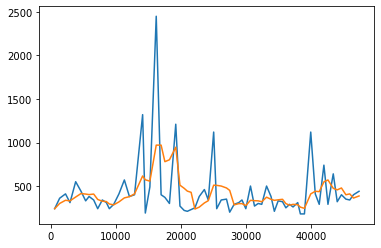

In [21]:
plt.plot(num_frames,y,num_frames,moving_average)

# Testing

This section deals with testing the models performance in pac-man and helping to visualize how its doing as well.

In [ ]:
dqn.load_model("The_real_stuff")
dqn.watch_play()

In [ ]:
dqn.test_model(test_games=10)

This will load up the selected model and run as many games as you want of it until they are all completed. Then it will take the average score, max score and the standatd deviation of all of these games to get a better sense of how its doing through getting a bigger sample. 

This will run a random instance of pac-man from a selected model and display it as a video in the notebook so you can see it real time. In the future I plan to make it so that you can save it to your google drive.